# HSI image StO2 estimation on INN model

## Preparation

In [1]:
%%capture

from google.colab import drive
drive.mount('/content/drive')

!pip install FrEIA
%cd /content/drive/MyDrive/Trial1/hvs_hsi_pytorch_colab
!pip install -e .

%cd /content/drive/MyDrive/Trial1/HVS_INN_MC_Project_colab

In [2]:
# %matplotlib notebook
name_model = "model_pig_1"
c = None
exec('import models.' + name_model + "_config as c")

from src.inn_model import *
from src.dataset import *
from src.visualisation import *
from tqdm import tqdm

import glob
import copy
import torch
import pandas as pd
import numpy as np

from hvs_hsi_pytorch.utils import hsi_utils, utils
from hvs_hsi_pytorch.hs_image import HSImage

In [3]:
# Read reformatted dataset
data_colon = pd.read_csv("data/mc/generic_train_15.7.15.4_power_led_300.csv")
train_df = data_colon[:int(len(data_colon) * 0.9)]

# Data loader
train_dataset = McDataset(train_df, c)
train_loader = data_utils.DataLoader(train_dataset, batch_size=c.batch_size, shuffle=True, drop_last=True)

# Set up dimensionality
c.ndim_y = train_dataset.get_y_dim()
c.ndim_x = train_dataset.get_x_dim()
c.ndim_tot = max(c.ndim_y, c.ndim_x) + c.ndim_z

# Model
model = inn_model(c)
model.load_state_dict(torch.load('models/' + name_model, map_location=torch.device(c.device)))
_ = model.eval()

In [10]:
# Read HSI image data
img_files = glob.glob("data/raw/*")
n_files, i_files = len(img_files), 0
for i in range(len(img_files)):
    print(('[*]' if i == i_files or i == n_files + i_files else '[ ]') + '\t%s' % (img_files[i].split('/')[-1]))

img_path = img_files[i_files]
white_path = "data/raw/exported_white_2022-06-29-15-43-31.png"

img = hsi_utils.load_frame(img_path)
white = hsi_utils.load_sample(white_path)

hsi_data = HSImage(array=img, wavelengths=None, camera="imec 4x4-VIS-15.7.15.4")
hsi_data.reconstruct(white=white, dark=None, rho=15, method="flatfield")
hsi_origin = copy.deepcopy(hsi_data)
hsi_data.array = utils.normalise_L1(hsi_data.array)

[*]	frame_012529_raw.png
[ ]	frame_012665_raw.png
[ ]	frame_012559_raw.png
[ ]	frame_012544_raw.png
[ ]	frame_012669_raw.png
[ ]	frame_012610_raw.png
[ ]	frame_012695_raw.png
[ ]	frame_012601_raw.png
[ ]	frame_012555_raw.png
[ ]	frame_012629_raw.png
[ ]	frame_012742_raw.png
[ ]	frame_012598_raw.png
[ ]	frame_012603_raw.png
[ ]	frame_012637_raw.png
[ ]	frame_012631_raw.png
[ ]	frame_012718_raw.png
[ ]	frame_012635_raw.png
[ ]	frame_012519_raw.png
[ ]	frame_012650_raw.png
[ ]	frame_012545_raw.png
[ ]	frame_012579_raw.png
[ ]	frame_012639_raw.png
[ ]	frame_012542_raw.png
[ ]	frame_012516_raw.png
[ ]	frame_012729_raw.png
[ ]	frame_012652_raw.png
[ ]	frame_012715_raw.png
[ ]	frame_012699_raw.png
[ ]	frame_012698_raw.png
[ ]	frame_012538_raw.png
[ ]	frame_012580_raw.png
[ ]	frame_012585_raw.png
[ ]	frame_012524_raw.png
[ ]	frame_012658_raw.png
[ ]	frame_012556_raw.png
[ ]	frame_012643_raw.png
[ ]	frame_012664_raw.png
[ ]	frame_012725_raw.png
[ ]	frame_012566_raw.png
[ ]	frame_012670_raw.png


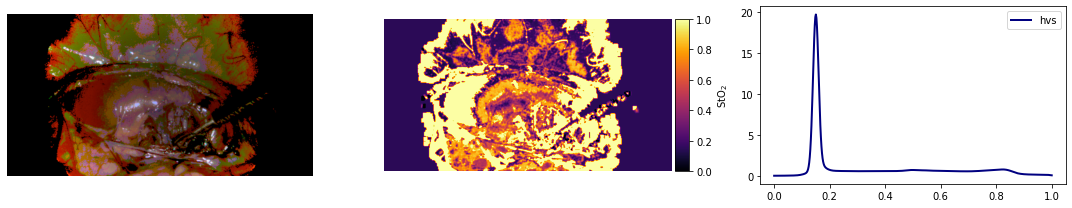

In [11]:
show_hvs_combo(hsi_origin, mask=False)

In [ ]:
%%time
# Data reformat
data = hsi_data.array
shape = data.shape
data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

step = 2 ** 13
batch = list(np.arange(data.shape[0], step=step))
batch.append(data.shape[0])

output = torch.tensor([])
for i in tqdm(range(len(batch) - 1), ascii=True, ncols=100):
    y = data[batch[i]:batch[i + 1]].to(c.device)
    z = torch.randn(y.shape[0], c.ndim_z).to(c.device)
    y = torch.cat((torch.zeros(y.shape[0], c.ndim_tot - c.ndim_y - c.ndim_z).to(c.device), y), dim=1)
    y = torch.cat((z, y), dim=1).to(c.device)
    pred_x = model(y, rev=True)[0][:, c.target].detach().cpu().clone()
    output = torch.cat((output, pred_x))

output = output.reshape(shape[1], shape[2])[:, :, None]

100%|#############################################################| 272/272 [00:06<00:00, 44.82it/s]

CPU times: user 4.21 s, sys: 105 ms, total: 4.31 s
Wall time: 6.08 s


## HVS Sto2 estimation

In [ ]:
# show_hvs_combo(hsi_origin, mask=False)

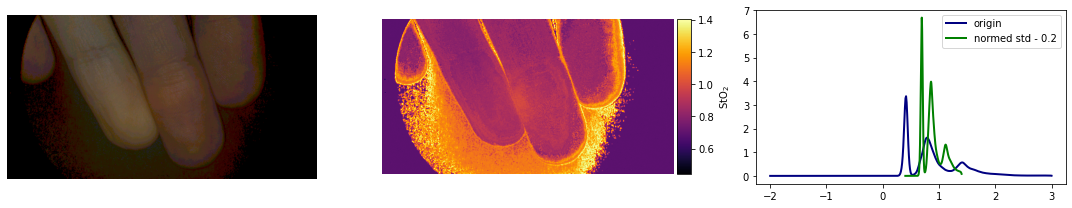

In [ ]:
show_inn_combo_norm(hsi_origin, output, mask=False)

In [ ]:
# show_inn_combo_origin(hsi_origin, output, mask=False, aim_range=(-0.3, 1.3))